Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.01098166 1.01098166
 1.01098166 1.01098166]
Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.01098166 1.01098166
 1.01098166 1.01098166]
Cell volume (bohr^3): 112.073152
Hartree energy (Hartree): 0.01052706
Hartree energy (eV): 0.286456 eV
Largest contrib #1: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #2: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #3: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617

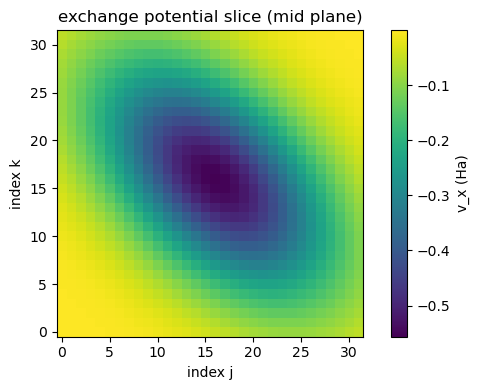

首个 G=0 分量 (v_x(G=0)) = -0.11686998356998642


In [ ]:
# 引用已有平面波/晶格函数，如果只需要晶格参数可删除下行
%run basis_func_with_kinetic.ipynb
%run Hartree.ipynb  # 提供 Gaussian 密度构造函数

import numpy as np
import matplotlib.pyplot as plt
import pylibxc

def lda_exchange_potential(rho, functional_name='lda_x'):
    """使用 libxc 计算局域密度近似 (LDA) 交换势，并保持与输入同形状。"""
    rho = np.asarray(rho, dtype=float)
    rho_flat = rho.reshape(-1)  # libxc 期望一维数组
    func = pylibxc.LibXCFunctional(functional_name, 'unpolarized')
    result = func.compute({'rho': rho_flat})
    epsilon_x = result['zk'].reshape(rho.shape)
    v_x = result['vrho'].reshape(rho.shape)
    return epsilon_x, v_x

def shared_gaussian_density(a0=4.05, Nk=32, sigma_bohr=1.0):
    """借助 Hartree.ipynb 中的构造函数获取统一的 Gaussian 密度。"""
    if 'build_gaussian_density' not in globals():
        raise RuntimeError('缺少 build_gaussian_density，请先成功运行 Hartree.ipynb。')
    return build_gaussian_density(a0=a0, Nk=Nk, sigma_bohr=sigma_bohr)

def exchange_potential_to_reciprocal(v_x, b_vecs):
    """将实空间交换势 v_x(r) 转换为倒空间 V_x(G) 及对应网格。"""
    if v_x.ndim != 3 or v_x.shape[0] != v_x.shape[1] or v_x.shape[1] != v_x.shape[2]:
        raise ValueError('v_x must be a cubic grid with shape (Nk, Nk, Nk).')
    Nk = v_x.shape[0]
    vx_fft = np.fft.fftn(v_x)
    vx_G = vx_fft / vx_fft.size
    freq = np.fft.fftfreq(Nk) * Nk
    mx, my, mz = np.meshgrid(freq, freq, freq, indexing='ij')
    Ggrid = (mx[..., None] * b_vecs[0] + my[..., None] * b_vecs[1] + mz[..., None] * b_vecs[2]) / Nk
    return vx_G, Ggrid

# ---------------- 示例：计算并展示交换势 ----------------
# if __name__ == '__main__':
#     rho_grid, Omega, Nk, a_vecs, r = shared_gaussian_density(a0=4.05, Nk=32, sigma_bohr=1.0)
#     eps_x, v_x = lda_exchange_potential(rho_grid)
#     b_vecs, _ = reciprocal_vectors(a_vecs)

#     print(f'电子密度网格形状: {rho_grid.shape}')
#     print(f'交换能密度均值: {eps_x.mean():.6e} Ha/bohr^3')
#     print(f'交换势范围: [{v_x.min():.6e}, {v_x.max():.6e}] Ha')

#     mid_slice = v_x[v_x.shape[0]//2, :, :]
#     plt.figure(figsize=(6,4))
#     im = plt.imshow(mid_slice, origin='lower', cmap='viridis')
#     plt.colorbar(im, label='v_x (Ha)')
#     plt.title('exchange potential slice (mid plane)')
#     plt.xlabel('index j')
#     plt.ylabel('index k')
#     plt.tight_layout()
#     plt.show()

#     vx_G, vx_Ggrid = exchange_potential_to_reciprocal(v_x, b_vecs)
#     print('首个 G=0 分量 (v_x(G=0)) =', vx_G.flat[0].real)
